In [1]:
from gpu_checker import is_gpu_free
try:
    is_gpu_free_flag = is_gpu_free()
except:
    is_gpu_free_flag = True

if not is_gpu_free_flag:
    raise Exception("GPU is not free at the moment")

In [2]:
import torch
import torch.nn as nn
import numpy as np
np.seterr(all='raise')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [3]:
# setup matplotlib
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
    SAVE_PLOTS = False
else:
    matplotlib.use('Agg')
    SAVE_PLOTS = True
import matplotlib.pyplot as plt

In [4]:
from utils import plot_spikes_in_time, print_and_plot_accuracy_metrics, plot_metrics
from scnn import SNN

from scnn.optim import RAdam

from data.data_augmentor import data_augment, batchify
from tools.time_expector import TimeExpector
from tools.notify import notify
time_expector = TimeExpector()

In [5]:
batch_size = 4
nb_frame = 30

class_limit = [0,1,2]#,3]#,4,5]#,6]#,7,8,9,10,11]
num_of_classes = len(class_limit)

# device = torch.device("cpu")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float
print("Device:", device)

Device: cpu


In [6]:

def get_data(trail, original_size, stop_counter=None):
    x_data = None
    y_data = None
    for _x, _y in batchify(
        trail,
        CACHE_FOLDER_PATH,
        condition_limit=['natural'],
        batch_size=original_size,
        augmentation=False,
        max_augmentation=1,
        frame=nb_frame
    ):
        if x_data is None:
            x_data = _x
            y_data = _y
        else:
            x_data = np.concatenate([x_data, _x])
            y_data = np.concatenate([y_data, _y])
            
        stop_counter -= 1
        if stop_counter == 0:
            break
    return x_data, y_data
    
def balance(data_x, data_y):
    _hist = {i:0 for i in range(12)}
    for i in data_y:
        _hist[i] += 1
    max_value = max(_hist.values())

    aug_xb = []
    aug_yb = []
    for i in range(12):
        idx = np.where(data_y == i)[0][0]
        to_add = max_value - _hist[i]
        for _ in range(to_add):
            aug_yb.append(i)
            aug_xb.append(data_x[idx, :, :, :])


    data_y = np.concatenate([data_y, np.array(aug_yb)])
    data_x = np.concatenate([data_x, np.array(aug_xb)])

    idx = np.zeros_like(data_y).astype(bool)
    for c in class_limit:
        idx[np.where(data_y == c)] = True
    data_x = data_x[idx]
    data_y = data_y[idx]
    
    return data_x, data_y


In [7]:
CACHE_FOLDER_PATH = "storage/dvs/cache"

    
# def load_data(trail):
# #     if test_run:
# #         trail = 'acc_test' # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<< Remove this >>>>>>>>>>>>>>>>
    
#     if trail.startswith('acc'):
#         max_augmentation = 1
#         augmentation = False
#     else:
#         max_augmentation = 2 if trail == 'train' else 1
#         augmentation = True
    
#     trail = trail.replace('acc_', '')
#     return batchify(
#         trail,
#         DATASET_FOLDER_PATH,
#         CACHE_FOLDER_PATH,
#         condition_limit=['natural'],
#         batch_size=batch_size,
#         augmentation=augmentation,
#         max_augmentation=max_augmentation,
#         frame=nb_frame
#     )

STOP_AFTER = 1 # -1 for all dataset
train_original_size = 512
test_original_size = 256

__xb_train, __yb_train = balance(*get_data('train', train_original_size, STOP_AFTER))
__xb_test, __yb_test = balance(*get_data('test', test_original_size, STOP_AFTER))

def load_data(trail):
    trail = trail.replace('acc_', '')
    c_xb = __xb_train if trail == 'train' else __xb_test
    c_yb = __yb_train if trail == 'train' else __yb_test
    
    
    begin = 0
    end = begin + batch_size
    while end <= c_yb.shape[0]:
        if class_limit is not None:
            for c in range(c_yb.shape[0]):
                if c_yb[c] not in class_limit:
                    c_yb[c] = 0
        yield c_xb[begin:end, :, :, :], c_yb[begin:end]
        begin = end
        end = begin + batch_size
        
print(__xb_train.shape)
print(__yb_train.shape)
print(__xb_test.shape)
print(__yb_test.shape)

(387, 30, 64, 64)
(387,)
(183, 30, 64, 64)
(183,)


pre-processing dataset: 96
pre-processing dataset: 45


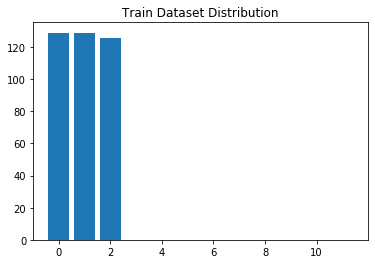

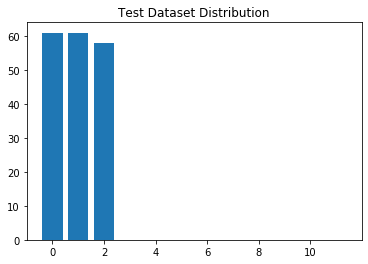

In [8]:
# calculate train dataset size
train_hist = {i:0 for i in range(12)}
test_hist = {i:0 for i in range(12)}
dataset_size = [0., 0.]
for x_batch, y_batch in load_data('train'):
    for i in y_batch:
        train_hist[i] += 1
    dataset_size[0] += 1.
    if dataset_size[0] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[0], end='')
print('\rpre-processing dataset: %d' % dataset_size[0])

for x_batch, y_batch in load_data('test'):
    for i in y_batch:
        test_hist[i] += 1
    dataset_size[1] += 1.
    if dataset_size[1] % 64 == 1:
        print('\rpre-processing dataset: %d' % dataset_size[1], end='')
print('\rpre-processing dataset: %d' % dataset_size[1])

plt.bar(list(train_hist.keys()), list(train_hist.values()))
plt.title('Train Dataset Distribution')
plt.show()
plt.bar(list(test_hist.keys()), list(test_hist.values()))
plt.title('Test Dataset Distribution')
plt.show()

In [9]:
def plot_one_batch(network, batch_id=0):
    for xb, yb in load_data('test'):
        break
    network.plot_one_batch(xb, yb, batch_id)

In [10]:
# class LegacyDense2(LegacyDense):
#     def __init__(self, *args, **kwargs):
#         dropout_prop = kwargs.pop('dropout_prob', None)
#         super(LegacyDense2, self).__init__(*args, **kwargs)
#         self.dropout = None if dropout_prop is None else nn.Dropout(dropout_prop)

#     def forward(self, x):
#         batch_size = x.shape[0]
#         nb_steps = x.shape[1]

#         h1 = torch.einsum("abc,cd->abd", (x, self.w))
#         syn = torch.zeros((batch_size, self.output_shape), device=x.device, dtype=x.dtype)
#         mem = torch.zeros((batch_size, self.output_shape), device=x.device, dtype=x.dtype)

#         spk_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)
#         mem_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)

#         # Compute hidden layer activity
#         for t in range(nb_steps):
#             mthr = mem - 1.0
#             out = self.spike_fn(mthr)
#             rst = torch.zeros_like(mem)
#             c = (mthr > 0)
#             rst[c] = torch.ones_like(mem)[c]

#             new_syn = self._alpha * syn + h1[:, t]
#             new_mem = self._beta * mem + syn - rst

#             mem = new_mem
#             syn = new_syn

#             mem_rec[:, t, :] = mem
#             spk_rec[:, t, :] = out

#         self.spk_rec_hist = spk_rec.detach().cpu().numpy()
#         self.mem_rec_hist = mem_rec.detach().cpu().numpy()
        
#         if self.dropout:
#             return self.dropout(spk_rec)
#         else:
#             return spk_rec

In [11]:
# class CustomReadout(LegacyDense):
#     def __init__(self, *args, **kwargs):
#         self.reduction = kwargs.pop('time_reduction')
#         super(CustomReadout, self).__init__(*args, **kwargs)

#         self.w_i = torch.nn.Parameter(torch.empty((1)), requires_grad=True)
#         self.reset_parameters()
#         self.clamp()

#     def clamp(self):
#         # This is due to bug in the initialization
#         if 'w_i' not in self._parameters:
#             return
#         self.w_i.data.clamp_(0., 1.)

#     def reset_parameters(self):
#         # This is due to bug in the initialization
#         if 'w_i' not in self._parameters:
#             return
#         torch.nn.init.normal_(self.w, mean=self.w_init_mean, std=self.w_init_std * np.sqrt(1. / self.input_shape))
#         torch.nn.init.normal_(self.w_i, mean=0.2, std=0.2)
        
#     def get_trainable_parameters(self, lr=None, weight_decay=None):
#         res = [
#             {'params': self.w},
#             {'params': self.w_i},
#         ]

#         if lr is not None:
#             for r in res:
#                 r['lr'] = lr
#         if weight_decay is not None:
#             res[0]['weight_decay'] = weight_decay
#         return res
        
#     def get_wta_matrix(self, spk):
#         batch_size = spk.shape[0]
#         n1 = torch.ones(size=(self.output_shape,)).to(spk.device) * self.w_i
#         _wta = torch.einsum('ab,c->abc', spk, n1)
#         torch.einsum('...ii->...i', _wta)[...] = 0
#         wta_all = torch.sum(_wta, axis=1)
#         #wta_all = torch.einsum('ab,b->ab', wta_all, self.w_i)
#         return wta_all
        
#     def pre_forward(self, x):
#         batch_size = x.shape[0]
#         nb_steps = x.shape[1]

#         h1 = torch.einsum("abc,cd->abd", (x, self.w))
#         syn = torch.zeros((batch_size, self.output_shape), device=x.device, dtype=x.dtype)
#         mem = torch.zeros((batch_size, self.output_shape), device=x.device, dtype=x.dtype)

#         spk_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)
#         mem_rec = torch.zeros((batch_size, nb_steps, self.output_shape), dtype=x.dtype, device=x.device)

#         # Compute hidden layer activity
#         for t in range(nb_steps):
#             mthr = mem - 1.0
#             out = self.spike_fn(mthr)

#             rst = torch.zeros_like(mem)
#             c = (mthr > 0)
#             rst[c] = torch.ones_like(mem)[c]

#             new_syn = self._alpha * syn + h1[:, t]
#             new_mem = self._beta * mem + syn - rst

#             wta = self.get_wta_matrix(out)

#             mem = new_mem - wta
#             syn = new_syn

#             mem_rec[:, t, :] = mem
#             spk_rec[:, t, :] = out

#         self.spk_rec_hist = spk_rec.detach().cpu().numpy()
#         self.mem_rec_hist = mem_rec.detach().cpu().numpy()

#         return spk_rec
        
#     def forward(self, x):
#         forward_result = self.pre_forward(x)

#         output = None
#         if self.reduction == "rate":
#             output = torch.einsum('abc->ac', forward_result)

#         return output


In [12]:
# from scnn.BatchSpike.readin import ReadInLayer

# class TemporalReadin(ReadInLayer):
#     def __init__(self, *args, **kwargs):
#         super(TemporalReadin, self).__init__(*args, **kwargs)
#         self.output_channels = 30

#     def forward(self, x):
#         batch_size = x.shape[0]
#         nb_steps = x.shape[1]
#         out = torch.zeros(batch_size, self.output_channels, nb_steps, *self.output_shape)
#         for t in range(nb_steps):
#             for c in range(t+1):
# #                 print(x.shape)
# #                 print(out.shape)
#                 out[:, t, t-c, :, :] = x[:, t, :, :]

#         if self.flatten_output:
#             out = out.view(batch_size, nb_steps, self.output_channels * np.prod(self.output_shape))
#         else:
#             out = out.view(batch_size, self.output_channels, nb_steps, *self.output_shape)

#         self.spk_rec_hist = out.detach().cpu().numpy()
#         return out

Network Summery: I(1x64x64) => C3(64,k3) => P(2) => max(3)
Layer 0: average number of spikes=0.0232
Layer 1: average number of spikes=0.0549


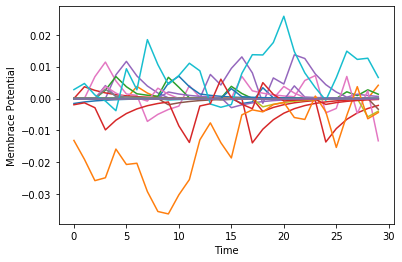

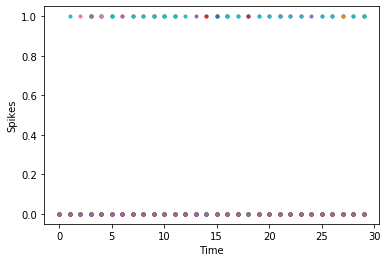

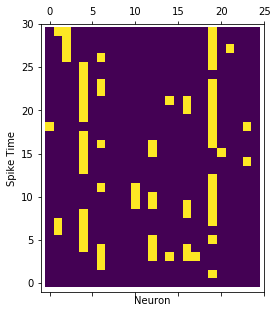

<Figure size 2160x1440 with 0 Axes>

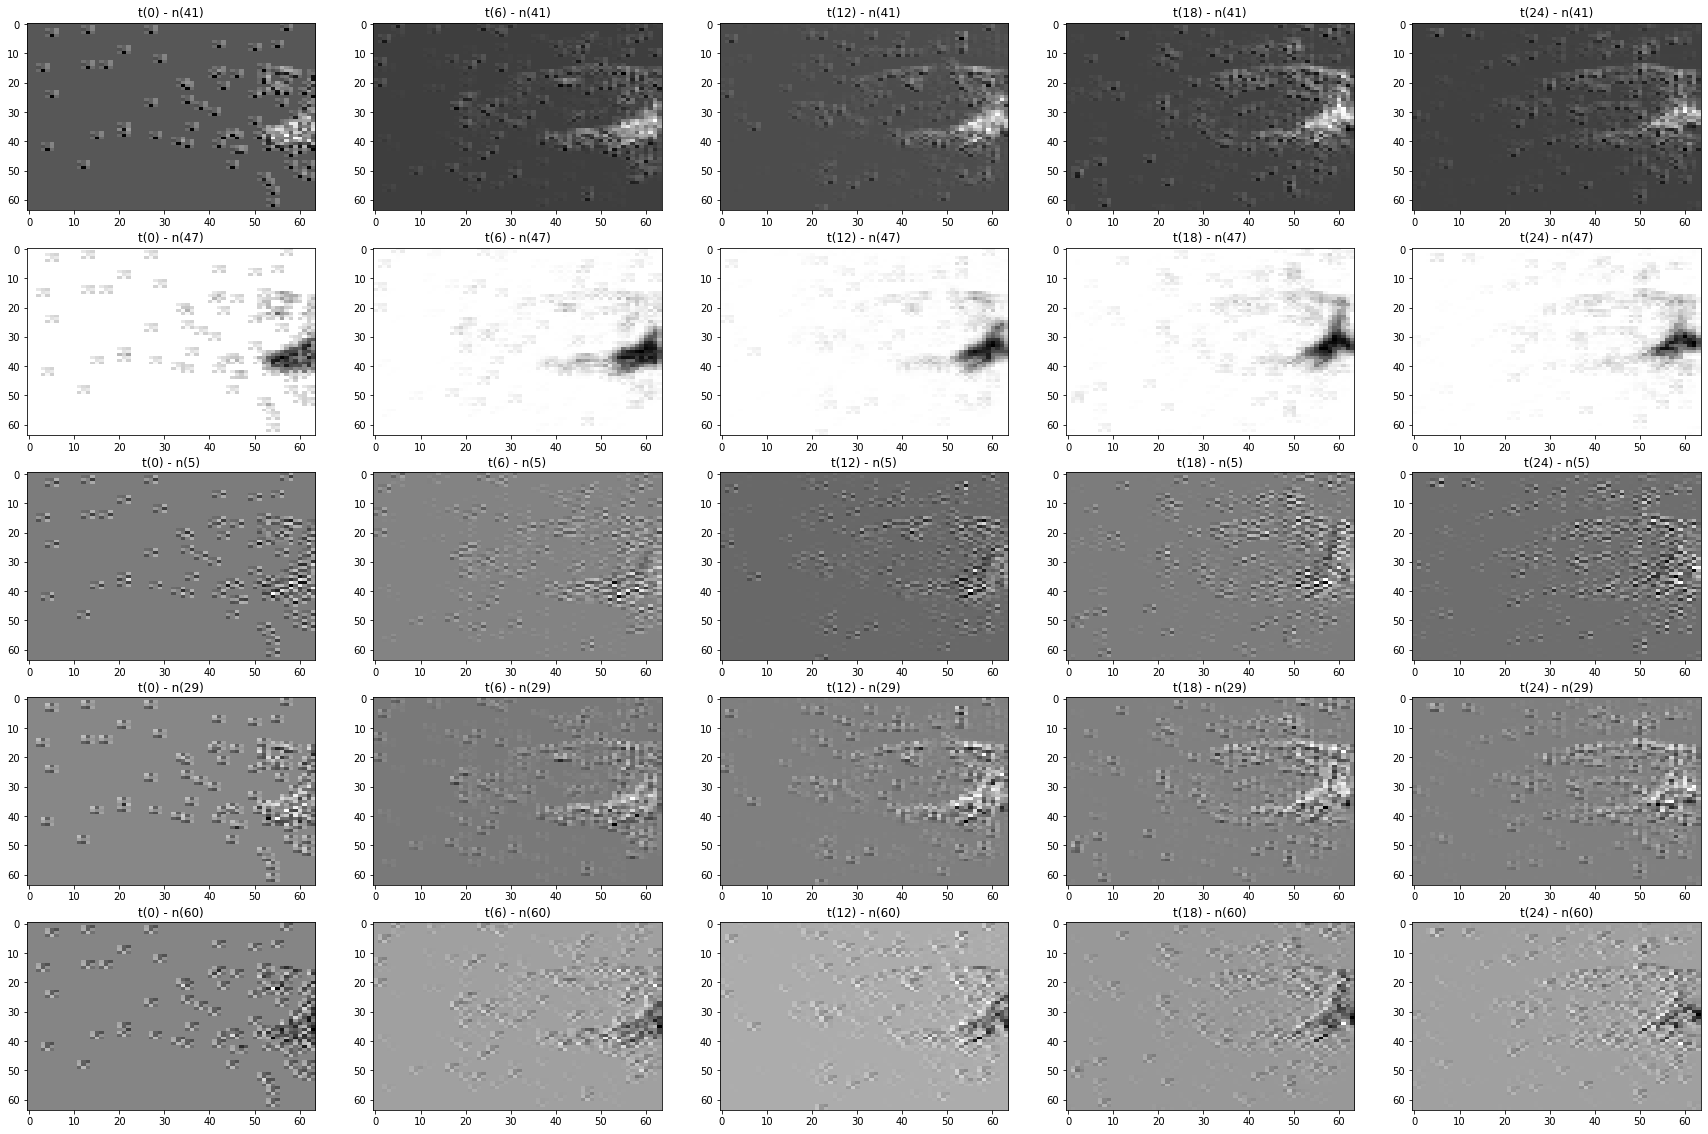

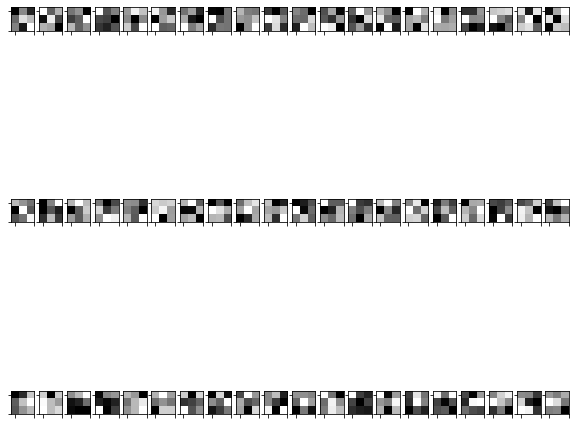

Layer 2: average number of spikes=0.1383


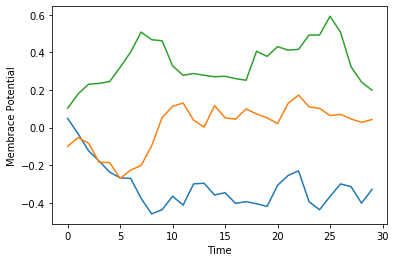

In [13]:
network = SNN(device=device, dtype=dtype)#, input_layer=TemporalReadin(input_shape=(64,64)))
network.network.time_expector = time_expector
# network.notifier = notify # FIXME

network.add_conv3d(
    input_shape=(64,64),
#     input_channels=30,
    
    output_channels=64,
    kernel_size=(1,3,3),
    dilation=(1,1,1),
    lateral_connections=False,
    recurrent=False,
    
    w_init_mean=0.00,
    w_init_std=0.05
)
network.add_pool2d(kernel_size=(2,2))

# network.add_conv3d(    
#     output_channels=128,
#     kernel_size=(30,3,3),
#     dilation=(1,1,1),
#     lateral_connections=False,
#     recurrent=False,
    
#     w_init_mean=0.00,
#     w_init_std=0.05
# )
# network.add_pool2d(kernel_size=(2,2))

# network.add_conv3d(    
#     output_channels=256,
#     kernel_size=(1,3,3),
#     dilation=(1,1,1),
#     lateral_connections=False,
#     recurrent=False,
    
#     w_init_mean=0.00,
#     w_init_std=0.05
# )
# network.add_pool2d(kernel_size=(2,2))


# network.add_dense(
# #     input_shape=(64,64),
# # network.add_layer(
# #     LegacyDense2,
    
#     output_shape=128,
#     w_init_mean=0.0,
#     w_init_std=0.8,
#     lateral_connections=False,
# #     dropout_prob=0.7,
# )

network.add_readout(
    output_shape=num_of_classes,
    time_reduction="max",

    w_init_mean=0.0,
    w_init_std=0.6
)


# network.add_layer(
#     CustomReadout,
#     output_shape=num_of_classes,
#     time_reduction="rate",

#     w_init_mean=0,
#     w_init_std=0.8,
#     lateral_connections=False,
# )


network.compile()


print('Network Summery:', network)
plot_one_batch(network)

In [ ]:
lr=1e-4
weight_decay=1e-5
epochs=5

with open('./logs/results.log', 'a+') as f:
    opt = RAdam(network.get_trainable_parameters(lr, weight_decay))
    #     opt = torch.optim.SGD(network.get_trainable_parameters(lr, weight_decay), lr=lr, momentum=0.9)
    res_metrics = network.fit(
        load_data, 
        epochs=epochs,
        optimizer=opt, 
        dataset_size=dataset_size, 
#         result_file=f,
        save_checkpoints=False
    )
    plot_metrics(res_metrics, save_plot_path='./logs/metrics_' if SAVE_PLOTS else None)

# network.save('./logs/save_network.net')
# network.load('./logs/save_network.net')


Epoch: 1 [>...........................................................]   1%                                   

In [ ]:
network.load_last_checkpoint()
plot_one_batch(network)
print_and_plot_accuracy_metrics(
    network, 
    load_data('acc_train'), 
    load_data('acc_test'), 
    save_plot_path='./logs/truth_' if SAVE_PLOTS else None
)